In [2]:
#neccessary imports
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import numpy as np
import scipy as sp
import qmcpy as qp
from scipy import stats
import sympy as sy
import sympy.stats
from scipy.stats import norm
import pickle
from timeit import default_timer as timer
from tqdm import tqdm

#not sure
import random
random.seed(100)

In [ ]:
#EXAMPLE 1: weighted sum of uniforms

def theFunc(u):
    return u[0] + 2*u[1] + 4*u[2]

def truePDF(y):
    n = len(y)
    output = [0.0] * n
    for i in range(n):
        if y[i] < 1 and y[i] > 0:
            output[i] = (1 / 16) * y[i]**2
        elif y[i] < 2 and y[i] > 1:
            output[i] = (1 / 16) + (1 / 8) * (y[i] - 1)
        elif y[i] < 3 and y[i] > 2:
            output[i] = (3 / 16) + (3 / 8) * (y[i] - 2) - (1 / 16) * (y[i]**2 - 4)
        elif y[i] < 4 and y[i] > 3:
            output[i] = 1/4
        elif y[i] < 5 and y[i] > 4:
            output[i] = (3 / 16) + (1 / 16) * (1 - (y[i] - 4)**2)
        elif y[i] < 6 and y[i] > 5:
            output[i] = (1 / 16) + (1 / 8) * (6 - y[i])
        elif y[i] < 7 and y[i] > 6:
            output[i] = (3 / 8) * (7 - y[i]) - (1 / 16) * (9 - (y[i] - 4)**2)
        else:
            output[i] = 0
    return output

def conditionalDensity1(y, x):
    test = y - x[1] - x[2]
    for j in range(len(test)):
        if test[j] > 0 and test[j] < 1:
            test[j] = 1
        else:
            test[j] = 0
    return test

def conditionalDensity2(y, x):
    test = y - x[0] - x[2]
    for j in range(len(test)):
        if test[j] > 0 and test[j] < 2:
            test[j] = 1/2
        else:
            test[j] = 0
    return test

def conditionalDensity3(y, x):
    test = y - x[0] - x[1]
    for j in range(len(test)):
        if test[j] > 0 and test[j] < 4:
            test[j] = 1/4
        else:
            test[j] = 0
    return test

#inverseCDFs expect only between (0, 1)
def inverseCDF1(y):
    return y

def inverseCDF2(y):
    return 2*y

def inverseCDF3(y):
    return 4*y


inverseCDFs = [inverseCDF1, inverseCDF2, inverseCDF3]
conditionalDensities = [conditionalDensity1, conditionalDensity2, conditionalDensity3]
start, end, nEval = 0, 7, 100
evalPoints = np.linspace(start, end, nEval)
Q = 25.5323059457 #take bandwidth = (Q / n) **(1/5) generally


$Y = f(X_1, X_2, X_3) = X_1 + X_2 + X_3$ for $X_j \sim \mathcal{U}(0, 2^{j-1})$
\
\
$Y = \mathcal{U}([0,1]) + 2\mathcal{U}([0,1]) + 4\mathcal{U}([0,1])$
\
\
$\rho_{\text{true}}(y) = \text{big piecewise function of lines, parabolas}$
\
\
$\rho(y | \mathcal{G}_{-k}) = \text{piecewise between constant and 0}$


In [94]:
#EXAMPLE 2: weighted sum of normals

weights = np.array([1, 0.5, 0.25, 0.125])
alpha = np.sqrt(np.sum(weights * weights))

def theFunc(u):
    return np.sum((weights / alpha) * norm.ppf(u), 0) #, 1?; 0?; , 0?

def truePDF(y):
    return norm.pdf(y)

def conditionalDensity1(y, x):
    return (alpha / weights[0]) * norm.pdf((1 / weights[0]) * (alpha*y - (np.sum(x, 0) - x[0])))

def conditionalDensity2(y, x):
    return (alpha / weights[1]) * norm.pdf((1 / weights[1]) * (alpha*y - (np.sum(x, 0) - x[1])))

def conditionalDensity3(y, x):
    return (alpha / weights[2]) * norm.pdf((1 / weights[2]) * (alpha*y - (np.sum(x, 0) - x[2])))

def conditionalDensity4(y, x):
    return (alpha / weights[3]) * norm.pdf((1 / weights[3]) * (alpha*y - (np.sum(x, 0) - x[3])))

#inverseCDFs expect only between (0, 1)
def inverseCDF1(y):
    return weights[0] * norm.ppf(y)

def inverseCDF2(y):
    return weights[1] * norm.ppf(y)

def inverseCDF3(y):
    return weights[2] * norm.ppf(y)

def inverseCDF4(y):
    return weights[3] * norm.ppf(y)


inverseCDFs = [inverseCDF1, inverseCDF2, inverseCDF3, inverseCDF4]
conditionalDensities = [conditionalDensity1, conditionalDensity2, conditionalDensity3, conditionalDensity4]
start, end, nEval = -3, 3, 100
evalPoints = np.linspace(start, end, nEval)
Q = 7.56053742316 #take bandwidth = (Q / n) **(1/5) generally


$Y = f(X_1, X_2, X_3, X_4) = \frac{1}{\alpha}(\sum_{i=1}^4 X_i) = \frac{1}{\alpha}(\sum_{i=1}^4 w_i Z_i)$ for $\alpha^2 = \sum_{i=1}^4 w_i^2$
\
\
$\rho_{\text{true}}(y) = \phi(x)$
\
\
$\rho(y | \mathcal{G}_{-k}) = \frac{\alpha}{w_k}\phi(\frac{1}{w_k}(\alpha y - \sum_{i\neq k}^4 X_i))$

In [68]:
#EXAMPLE 3: weighted product of uniforms


def theFunc(u):
    return 8*u[0]*u[1]*u[2]

def truePDF(y):
    output = [0] * len(y)
    for j in range(len(y)):
        if y[j] > 8 or y[j] < 0:
            output[j] = 0
        else:
            output[j] = (1/16) * (np.log(y[j] / 8))**2
    return output

def conditionalDensity1(y, x):
    test = y / (x[1]*x[2])
    for j in range(len(test)):
        if test[j] > 1 or test[j] < 0:
            test[j]=0
    return test / y

def conditionalDensity2(y, x):
    test = y / (x[0]*x[2])
    for j in range(len(test)):
        if test[j] > 2 or test[j] < 0:
            test[j] = 0
    return test / (2*y)

def conditionalDensity3(y, x):
    test = y / (x[0]*x[1])
    for j in range(len(test)):
        if test[j] > 4 or test[j] < 0:
            test[j] = 0
    return test / (4*y)

def inverseCDF1(y):
    return y

def inverseCDF2(y):
    return 2*y

def inverseCDF3(y):
    return 4*y

start, end = 0.01, 8
nEval = 100
evalPoints = np.linspace(start, end, nEval)
inverseCDFs = [inverseCDF1, inverseCDF2, inverseCDF3]
conditionalDensities = [conditionalDensity1, conditionalDensity2, conditionalDensity3]
Q = 0.00000565787743961

    


$Y = f(X_1, X_2, X_3) = X_1X_2X_3$ for $X_j \sim \mathcal{U}(0, 2^{j-1})$
\
\
$\rho_\text{true}(y) = \frac{1}{16}\ln(\frac{y}{8})^2$
\
\
$\rho(y \;|\; \mathcal{G}_{-k}) = (\Pi_{-k})^{-1}$ 

In [8]:
#EXAMPLE 4: Displacement of a cantilever beam



mu = np.array([2.9e+07, 500, 1000])
sigma = np.array([1.45e+06, 100, 100])

l = 100
w = 4
t = 2
kappa = 4*l**3 / (w*t)

def theFunc(u):
    term1 = kappa / (sigma[0] * norm.ppf(u[0]) + mu[0])
    term2 = np.sqrt(((sigma[1] * norm.ppf(u[1]) + mu[1])**2) / (w**4) + ((sigma[2] * norm.ppf(u[2]) + mu[2])**2) / (t**4))
    return term1 * term2


def truePDF(y):
    raise Exception("there is no known truePDF!")
    return True

def conditionalDensity1(y, x):
    def W1(y, x):
        return (kappa / y) * np.sqrt(x[1]**2 / (w**4) + x[2]**2 / (t**4))
    return (1 / (y * sigma[0])) * W1(y,x) * norm.pdf((W1(y, x) - mu[0]) / sigma[0])



def conditionalDensity2(y, x):
    n = len(y)
    output = np.array([0.0] * n)
    def W2(y, x):
        return (w**4) * ((y * x[0] / kappa)**2 - (x[2]**2 / (t**4)))
    
    for i in range(n):
        if W2(y[i], x) <= 0:
            output[i] = 0
        else:
            def sqrtW2(y,x):
                return np.sqrt(W2(y,x))
            
            numer = norm.pdf((sqrtW2(y[i],x) - mu[1]) / sigma[1]) + norm.pdf(-(sqrtW2(y[i],x) + mu[1]) / sigma[1])
            denom = (sigma[1]*sqrtW2(y[i], x)) / ((w**4)*y[i]*(x[0] / kappa)**2)
            output[i] = numer / denom
    return output



def conditionalDensity3(y, x):
    n = len(y)
    output = np.array([0.0] * n)
    def W3(y, x):
        return (t**4) * ((y * x[0] / kappa)**2 - (x[1]**2 / (w**4)))
    
    for i in range(n):
        if W3(y[i], x) <= 0:
            output[i] = 0
        else:
            def sqrtW3(y,x):
                return np.sqrt(W3(y,x))
            
            numer = norm.pdf((sqrtW3(y[i],x) - mu[2]) / sigma[2]) + norm.pdf(-(sqrtW3(y[i],x) + mu[2]) / sigma[2])
            denom = (sigma[2]*sqrtW3(y[i], x)) / ((t**4)*y[i]*(x[0] / kappa)**2)
            output[i] = numer / denom
    return output


#inverseCDFs expect only between (0, 1)
def inverseCDF1(y):
    return sigma[0]*norm.ppf(y) + mu[0]

def inverseCDF2(y):
    return sigma[1]*norm.ppf(y) + mu[1]

def inverseCDF3(y):
    return sigma[2]*norm.ppf(y) + mu[2]


inverseCDFs = [inverseCDF1, inverseCDF2, inverseCDF3]
conditionalDensities = [conditionalDensity1, conditionalDensity2, conditionalDensity3]
start, end, nEval = 3.1707, 5.6675, 100
evalPoints = np.linspace(start, end, nEval)
Q = 0.5 #take bandwidth = (Q / n) **(1/5) generally


$Y = f(X_1, X_2, X_3) = \frac{4l^3}{X_1wt}\sqrt{{\frac{X_2^2}{w^4}} + {\frac{X_3^2}{t^4}}}$ for $X_j \sim \mathcal{N}(\mu_j, \sigma_j^2)$
\
Want / have to make some simplifications: $X_1 \geq 0$ (happens with probability ~ $10^{-89}$)
\
\
$\rho_\text{true}(y) = ??? \quad \text{isn't known}$
\
\
$\rho(y \; | \; \mathcal{G}_{-k}) = \text{something complicated, a little piecewise, but fully closed form}$
\
\
This example is taken from Monte Carlo and Quasi-Monte Carlo Density Estimation via Condition by L'Ecuyer, Puchhammer, and Abdellah

In [75]:
#EXAMPLE 5: LARGE (15) sum of standard normals (standardized)


weights = np.ones(15)
# for i in range(15):
#     weights[i] = 1 / (i+1)
alpha = np.sqrt(np.sum(weights * weights))

def theFunc(u):
    return np.sum((weights / alpha) * norm.ppf(u), 0)

def truePDF(y):
    return norm.pdf(y)

def conditionalDensity1(y, x):
    return (alpha / weights[0]) * norm.pdf((1 / weights[0]) * (alpha*y - (np.sum(x, 0) - x[0])))

def conditionalDensity2(y, x):
    return (alpha / weights[1]) * norm.pdf((1 / weights[1]) * (alpha*y - (np.sum(x, 0) - x[1])))

def conditionalDensity3(y, x):
    return (alpha / weights[2]) * norm.pdf((1 / weights[2]) * (alpha*y - (np.sum(x, 0) - x[2])))

def conditionalDensity4(y, x):
    return (alpha / weights[3]) * norm.pdf((1 / weights[3]) * (alpha*y - (np.sum(x, 0) - x[3])))

def conditionalDensity5(y, x):
    return (alpha / weights[4]) * norm.pdf((1 / weights[4]) * (alpha*y - (np.sum(x, 0) - x[4])))

def conditionalDensity6(y, x):
    return (alpha / weights[5]) * norm.pdf((1 / weights[5]) * (alpha*y - (np.sum(x, 0) - x[5])))

def conditionalDensity7(y, x):
    return (alpha / weights[6]) * norm.pdf((1 / weights[6]) * (alpha*y - (np.sum(x, 0) - x[6])))

def conditionalDensity8(y, x):
    return (alpha / weights[7]) * norm.pdf((1 / weights[7]) * (alpha*y - (np.sum(x, 0) - x[7])))

def conditionalDensity9(y, x):
    return (alpha / weights[8]) * norm.pdf((1 / weights[8]) * (alpha*y - (np.sum(x, 0) - x[8])))

def conditionalDensity10(y, x):
    return (alpha / weights[9]) * norm.pdf((1 / weights[9]) * (alpha*y - (np.sum(x, 0) - x[9])))

def conditionalDensity11(y, x):
    return (alpha / weights[10]) * norm.pdf((1 / weights[10]) * (alpha*y - (np.sum(x, 0) - x[10])))

def conditionalDensity12(y, x):
    return (alpha / weights[11]) * norm.pdf((1 / weights[11]) * (alpha*y - (np.sum(x, 0) - x[11])))

def conditionalDensity13(y, x):
    return (alpha / weights[12]) * norm.pdf((1 / weights[12]) * (alpha*y - (np.sum(x, 0) - x[12])))

def conditionalDensity14(y, x):
    return (alpha / weights[13]) * norm.pdf((1 / weights[13]) * (alpha*y - (np.sum(x, 0) - x[13])))

def conditionalDensity15(y, x):
    return (alpha / weights[14]) * norm.pdf((1 / weights[14]) * (alpha*y - (np.sum(x, 0) - x[14])))

#inverseCDFs expect only between (0, 1)
def inverseCDF1(y):
    return weights[0] * norm.ppf(y)

def inverseCDF2(y):
    return weights[1] * norm.ppf(y)

def inverseCDF3(y):
    return weights[2] * norm.ppf(y)

def inverseCDF4(y):
    return weights[3] * norm.ppf(y)

def inverseCDF5(y):
    return weights[4] * norm.ppf(y)

def inverseCDF6(y):
    return weights[5] * norm.ppf(y)

def inverseCDF7(y):
    return weights[6] * norm.ppf(y)

def inverseCDF8(y):
    return weights[7] * norm.ppf(y)

def inverseCDF9(y):
    return weights[8] * norm.ppf(y)

def inverseCDF10(y):
    return weights[9] * norm.ppf(y)

def inverseCDF11(y):
    return weights[10] * norm.ppf(y)

def inverseCDF12(y):
    return weights[11] * norm.ppf(y)

def inverseCDF13(y):
    return weights[12] * norm.ppf(y)

def inverseCDF14(y):
    return weights[13] * norm.ppf(y)

def inverseCDF15(y):
    return weights[14] * norm.ppf(y)


inverseCDFs = [inverseCDF1, inverseCDF2, inverseCDF3, inverseCDF4, inverseCDF5,
               inverseCDF6, inverseCDF7, inverseCDF8, inverseCDF9, inverseCDF10,
               inverseCDF11, inverseCDF12, inverseCDF13, inverseCDF14, inverseCDF15]
conditionalDensities = [conditionalDensity1, conditionalDensity2, conditionalDensity3, conditionalDensity4, conditionalDensity5,
                        conditionalDensity6, conditionalDensity7, conditionalDensity8, conditionalDensity9, conditionalDensity10,
                        conditionalDensity11, conditionalDensity12, conditionalDensity13, conditionalDensity14, conditionalDensity15]
                        
start, end, nEval = -3, 3, 100
evalPoints = np.linspace(start, end, nEval)
Q = 7.56053742316 #take bandwidth = (Q / n) **(1/5) generally


Just a sum of standard normal variables standardized: $Y = \frac{1}{\sqrt{15}}(Z_1 + ... + Z_{15}) \sim Z$

In [3]:
def kernelDensityEstimator(y, pointSet, bandwidth): 
    n = len(pointSet)
    def kernel(z): #gaussian kernel
         return np.exp(-z**2) / math.sqrt(math.pi)
    sum = 0
    for i in range(n):
        sum += (1 / (n*bandwidth)) * kernel((y - theFunc(pointSet[i])) / bandwidth)
    return sum



def conditionalEstimator(y, conditionalDensity, realizations):
    output = 0
    for j in range(realizations[:, 0].size):
        output += conditionalDensity(y, realizations[j]) / realizations[:, 0].size
    return output

In [4]:
def getEvaluatedPoints(pointSetType, n, method, conditionalDensity, bandwidth, inverseCDFs, evalPoints):
    dimension = len(inverseCDFs)
    if n <= 0:
        raise Exception("n must be a positive integer")
    
    if pointSetType == "MC":
        pointSet = qp.IIDStdUniform(dimension).gen_samples(n)
    elif pointSetType == "Sobol":
        pointSet = qp.Sobol(dimension).gen_samples(n)
    else:
        raise Exception("Currently supported pointSetTypes are MC and Sobol")
    if method == "KDE":
        evaluatedPoints = kernelDensityEstimator(evalPoints, pointSet, bandwidth)
    elif method == "conditional":
        realizations = np.array([[0.0] * dimension] * n)
        for i in range(dimension):
            realizations[:, i] = inverseCDFs[i](pointSet[:, i])
        evaluatedPoints = conditionalEstimator(evalPoints, conditionalDensity, realizations)
    else:
        raise Exception("Valid methods are KDE or conditional")
    return evaluatedPoints

def getTrueError(evaluatedPoints, evalPoints):
    nPoints = len(evalPoints)
    estimatedError = ((end - start) / nPoints) * np.sum((evaluatedPoints - truePDF(evalPoints))**2)
    return estimatedError

def averageErrorLog(pointSetType, n, method, conditionalDensity, bandwidth, inverseCDFs, averageAcross, evalPoints):
    sum = 0
    for i in range(averageAcross):
        evaluatedPoints = getEvaluatedPoints(pointSetType, n, method, conditionalDensity, bandwidth, inverseCDFs, evalPoints)
        sum += (1 / averageAcross) * getTrueError(evaluatedPoints, evalPoints)
    return -np.log10(sum)

In [5]:
def printSaveErrorTable(methods, pointSetTypes, conditionalDensities, start, stop, increment, averageOver, Qval, evalPoints):
    db = {}
    xvals = np.array(range(start, stop, increment)) * np.log10(2)
    for method in methods:
        if method == "conditional":
            for conditionalDensity in conditionalDensities:
                for pointSetType in pointSetTypes:
                    output = []
                    for exp in range(start, stop, increment):
                        output.append(averageErrorLog(pointSetType, 2**exp, method, conditionalDensity, "N/A bandwidth", inverseCDFs, averageOver, evalPoints))
                    print(pointSetType, method, conditionalDensity.__name__, output)
                    nu = stats.linregress(xvals, output).slope
                    db[pointSetType, method, conditionalDensity.__name__] = (output, nu)
        elif method == "KDE":
            for pointSetType in pointSetTypes:
                output = []
                for exp in range(start, stop, increment):
                    n = 2**exp
                    output.append(averageErrorLog(pointSetType, n, method, "no conditional density", (Qval / n)**(1/5), inverseCDFs, averageOver, evalPoints))
                print(pointSetType, method, output)
                nu = stats.linregress(xvals, output).slope
                db[pointSetType, method] = (output, nu)
    return db

def calculateEstimatedMISE(samplePoints):
    predictedVarVec = np.array([0.0] * nEval)
    for j in range(nEval):
        predictedVarVec[j] = np.var(samplePoints[:,j])
    return ((end - start) / nEval) * np.sum(predictedVarVec)

def generatePointsforCalculateEstimatedMISE(pointSetType, n, method, conditionalDensity, bandwidth, inverseCDFs, evalPoints, nr):
    samplePoints = np.array([[0.0] * nEval] * nr)
    for i in range(nr):
        samplePoints[i] = getEvaluatedPoints(pointSetType, n, method, conditionalDensity, bandwidth, inverseCDFs, evalPoints)
    return samplePoints



In [6]:
def generateSeparatePlots(n, densitiesToPlot, wantTrue, wantSeparate):
    numConditional = len(densitiesToPlot)
    dimension = len(inverseCDFs)

    evaluatedPoints = [0.0] * (numConditional + 1)
    for i in range(numConditional):
        evaluatedPoints[i] = getEvaluatedPoints('Sobol', n, 'conditional', densitiesToPlot[i], "no bandwidth", inverseCDFs, evalPoints)
    

    bandwidth = (Q / n) ** (1/5)
    sobolPoints = qp.Sobol(dimension).gen_samples(n)
    evaluatedPoints[numConditional] = kernelDensityEstimator(evalPoints, sobolPoints, bandwidth)
    
    mpl.style.use('seaborn-v0_8-darkgrid')
    
    if wantSeparate == True:
        fig, ax = plt.subplots(1, numConditional + 1, figsize = (24, 6))
        for i in range(numConditional + 1):
            if i < numConditional:
                name = densitiesToPlot[i].__name__
            else:
                name = "KDE"
            ax[i].plot(evalPoints, evaluatedPoints[i], label = f"{name}", color = "red")
            if wantTrue == True:
                truePoints = truePDF(evalPoints)
                ax[i].plot(evalPoints, truePoints, label = "truePDF", color = "green")
            ax[i].legend() 

    else:
        for i in range(numConditional + 1):
            if i < numConditional:
                name = densitiesToPlot[i].__name__
            else:
                name = "KDE"
            plt.plot(evalPoints, evaluatedPoints[i], "--",label = f"{name}")
        if wantTrue == True:
            truePoints = truePDF(evalPoints)
            plt.plot(evalPoints, truePoints, label = "truePDF", color = "green")
        plt.legend()
        plt.figure(figsize = (16,12))

EVERYTHING ABOVE ARE JUST FUNCTIONS

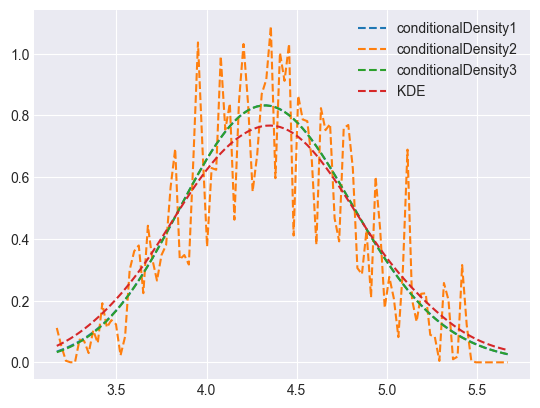

<Figure size 1600x1200 with 0 Axes>

In [75]:
#plot everything in example
generateSeparatePlots(2**8, conditionalDensities, False, False)

In [19]:
#trying to approximate uniform with a nonsymmetric normal kernel

def tempFunc(x):
    return x

def truePDF(x):
    output = np.zeros(len(x))
    for i in range(len(x)):
        if x[i] < 0 or x[i] > 1:
            output[i] = 0
        else:
            output[i] = 1
    return output

def nonSymKDE(y, pointSet, bandwidth, maxSkew, start, end, style): 
    n = len(pointSet)
    def kernel(z, alpha):
        return 2* norm.pdf(z) * norm.cdf(alpha * z)
    sum = 0
    for i in range(n):
        if style == "linear":
            alpha = -(2 * maxSkew / (end - start)) * (tempFunc(pointSet[i]) - start) + maxSkew #linear alpha
        elif style == "cubic":
            alpha = -(maxSkew / ((end / 2 - start / 2)**3)) * (tempFunc(pointSet[i]) - ((end + start) / 2))**3 #cubic alpha
        elif style == "quintic":
            alpha = -(maxSkew / ((end / 2 - start / 2)**5)) * (tempFunc(pointSet[i]) - ((end + start) / 2))**5 #quintic alpha

        sum += (1 / (n*bandwidth)) * kernel((y - tempFunc(pointSet[i])) / bandwidth, alpha)
    return sum

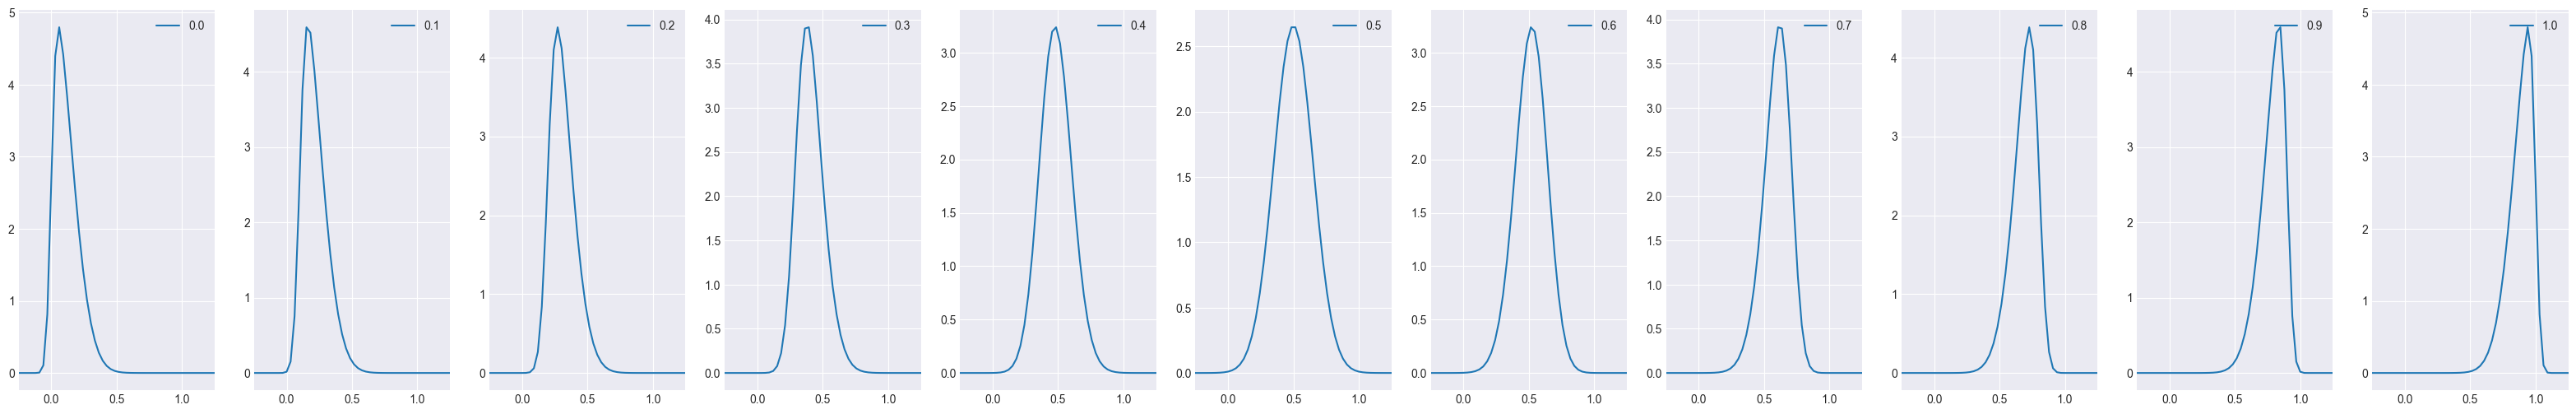

In [20]:
#pl
nRange = 11
plotPoints = np.linspace(-1, 2, 100)
fig, ax = plt.subplots(1, nRange, figsize = (40, 6))
for i in range(nRange):
    ax[i].plot(plotPoints, nonSymKDE(plotPoints, [i * 0.1], 0.15, 5, 0, 1, style= "linear"), label = f"{np.round(i * 0.1, 2)}")
    ax[i].set_xlim(-0.25, 1.25)
    ax[i].legend(loc = "upper right")

In [ ]:
#make plots and error based on stuff
truePoints = truePDF(tempEvalPoints)
fig, ax = plt.subplots(1, 2, figsize = (18, 9))
bandwidth = 0.1
for style in ["linear", "quintic"]:
    i=0
    for maxSkew in np.linspace(0, 4, 5):
        yvals = nonSymKDE(y=tempEvalPoints, pointSet=qp.Sobol(1).gen_samples(2**12), bandwidth=bandwidth, maxSkew=maxSkew, start=0, end=1, style=style)
        error = ((1 - 0) / 100) * np.sum((yvals - truePoints)**2)
        if style == "linear":
            if maxSkew == 0:
                ax[0].plot(tempEvalPoints, yvals, label = "sym")
            else:
                ax[0].plot(tempEvalPoints, yvals)
        if style == "quintic":
            if maxSkew == 0:
                ax[1].plot(tempEvalPoints, yvals, label = "sym")
            else:
                ax[1].plot(tempEvalPoints, yvals)
        print(maxSkew, style, -np.log2(error))


# def theFunc(x):
#     return x
# ax[0].plot(tempEvalPoints, kernelDensityEstimator(tempEvalPoints, qp.Sobol(1).gen_samples(2**12), bandwidth * np.sqrt(2)), label = "same")
# ax[1].plot(tempEvalPoints, kernelDensityEstimator(tempEvalPoints, qp.Sobol(1).gen_samples(2**12), bandwidth * np.sqrt(2)), label = "same")
ax[0].plot(tempEvalPoints, truePoints, label = "true")
ax[1].plot(tempEvalPoints, truePoints, label = "true")
ax[0].legend()
ax[1].legend()
print(f"effective bandwidth with gaussian kernel is {bandwidth * np.sqrt(2)}")



In [ ]:
#really ugly all plots
fig,ax = plt.subplots()
tempEvalPoints = np.linspace(-1, 2, 100)
for maxSkew in np.linspace(0, 5, 6):
    for style in ["linear", "cubic", "quintic"]:
        yvals = nonSymKDE(y=tempEvalPoints, pointSet=qp.Sobol(1).gen_samples(2**13), bandwidth=0.02, maxSkew=maxSkew, start=0, end=1, style=style)
        
        plt.plot(tempEvalPoints, yvals, label = f"{round(maxSkew, 2), style}")
ax.legend()

In [96]:
#gets estimated error for each condition with known truePDF
nr = 16
dict = {}
expStart, expStop, expIncrement = 10, 15, 1  #4, 10, 1
expVals = np.array(range(expStart, expStop, expIncrement))
for method in ["conditional", "KDE"]:
    for pointSetType in ["Sobol", "MC"]:
        if method == "conditional":
            for conditionalDensity in conditionalDensities:
                output = []
                for exp in range(expStart, expStop, expIncrement):
                    n = 2**exp
                    evaluatedPoints = getEvaluatedPoints(pointSetType, n, method, conditionalDensity, "no bandwidth", inverseCDFs, evalPoints)
                    output.append(getTrueError(evaluatedPoints, evalPoints))
                logOutput = -np.log10(output)
                slope = stats.linregress(expVals * np.log10(2), logOutput).slope
                dict[pointSetType, method, conditionalDensity.__name__] = logOutput, slope
                print(pointSetType, method, conditionalDensity.__name__, logOutput, slope)
        if method == "KDE":
            output = []
            for exp in range(expStart, expStop, expIncrement):
                n = 2**exp
                bandwidth = 2.67224008 * (n**(-0.211478528))
                evaluatedPoints = getEvaluatedPoints(pointSetType, n, method, "no conditionalDensity", bandwidth, inverseCDFs, evalPoints)
                output.append(getTrueError(evaluatedPoints, evalPoints))
            logOutput = -np.log10(output)
            slope = stats.linregress(expVals * np.log10(2), logOutput).slope
            dict[pointSetType, method] = logOutput, slope
            print(pointSetType, method, 2.67224008, logOutput, slope)


Sobol conditional conditionalDensity1 [10.49062014 11.16188952 11.80682788 12.05709851 12.88546676 13.34273789] 1.8680237290960202
Sobol conditional conditionalDensity2 [ 8.18397096  9.35937661  9.04650045  9.99427848 10.69925031 11.65757261] 2.119903352522976
Sobol conditional conditionalDensity3 [6.44467181 6.89986431 7.88546699 8.29921842 8.77029532 9.25912431] 1.9074802452199509
Sobol conditional conditionalDensity4 [5.10361436 5.90177964 6.60852381 6.80544132 7.35117604 8.07578517] 1.8418630325257217
MC conditional conditionalDensity1 [4.66672309 5.50563564 7.14915068 7.08072506 6.79574567 8.12268281] 2.0009114779345127
MC conditional conditionalDensity2 [5.46177915 5.24180844 5.39643249 5.70158561 6.48026806 6.28450628] 0.772031999773039
MC conditional conditionalDensity3 [3.99477092 4.90018716 4.66898318 5.0745135  5.41074884 5.68579936] 0.986361842675703
MC conditional conditionalDensity4 [3.58946933 4.27064271 4.72589527 4.75692304 5.28027355 5.31506082] 1.109322553848752
Sobo

In [ ]:
#gets estimated error for each condition
nr = 16
dict = {}
expStart, expStop, expIncrement = 6, 12, 1 #4, 10, 1
expVals = np.array(range(expStart, expStop, expIncrement))
for pointSetType in ["Sobol", "MC"]:
    for method in ["conditional", "KDE"]:
        if method == "conditional":
            for conditionalDensity in conditionalDensities:
                output = []
                for exp in range(expStart, expStop, expIncrement):
                    n = 2**exp
                    output.append(calculateEstimatedMISE(generatePointsforCalculateEstimatedMISE(pointSetType, n, method, conditionalDensity, 
                                                               "no bandwidth", inverseCDFs, evalPoints, nr)))
                logOutput = -np.log2(output)
                slope = stats.linregress(expVals, logOutput).slope
                dict[pointSetType, method, conditionalDensity.__name__] = logOutput, slope
                print(pointSetType, method, conditionalDensity.__name__, logOutput, slope)
        if method == "KDE":
            output = []
            for exp in range(expStart, expStop, expIncrement):
                n = 2**exp
                output.append(calculateEstimatedMISE(generatePointsforCalculateEstimatedMISE(pointSetType, n, method, "no conditionalDensity", 
                                                               (Q / n)**(1/5), inverseCDFs, evalPoints, nr)))
            logOutput = -np.log2(output)
            slope = stats.linregress(expVals, logOutput).slope
            dict[pointSetType, method] = logOutput, slope
            print(pointSetType, method, Q, logOutput, slope)


In [10]:
#calculates estimated error for experiment2
dbfile = open('experiment2Corrected', 'rb')
db = pickle.load(dbfile)
localDb = db

xvals = np.array(range(5, 15, 1))
for conditionalDensity in conditionalDensities:
    output = []
    for exp in range(5, 15 , 1):
        temp = -np.log2(calculateEstimatedMISE(localDb["Sobol", "conditional", conditionalDensity.__name__, exp]))
        output.append(temp)

    print(conditionalDensity.__name__)
    print(f"error for n = 2^14 is {output[-1]}")
    print(f"fitted slope = {stats.linregress(xvals, output).slope}")
dbfile.close()

conditionalDensity1
error for n = 2^14 is 33.003495710549586
fitted slope = 2.440339154837346
conditionalDensity2
error for n = 2^14 is 13.466555006319789
fitted slope = 1.404029137885013
conditionalDensity3
error for n = 2^14 is 36.4828265191413
fitted slope = 2.214254840496351


In [11]:
#gives log2 error for KDE of specified badnwidth (true points are just high sample RQMC conditional)
kdeNR = 16
n = 2**14
bandwidth = 0.365088 * n**(-0.27275)
temp = generatePointsforCalculateEstimatedMISE("Sobol", n, "KDE", "no conditionalDensity", bandwidth, inverseCDFs, evalPoints, kdeNR)
IV = calculateEstimatedMISE(temp)
mean = np.mean(temp, 0)
truePoints = localDb["Sobol", "conditional", "conditionalDensity3", 14][6]
ISB = ((end - start) / nEval) *np.sum((mean - truePoints)**2)
print(-np.log2(IV + ISB))


13.62452952441138


KeyboardInterrupt: 

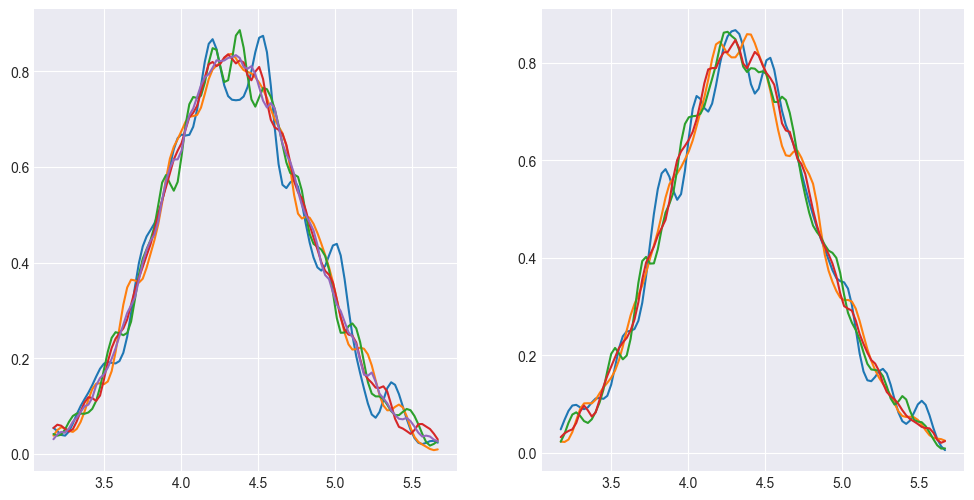

In [90]:
#plotting KDE of different bandwidths
truePoints = localDb["Sobol", "conditional", "conditionalDensity3", 14][6]
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
for exp in range(8, 15, 1):
    n = 2**exp
    bandwidth = 0.365088 * n**(-0.27275)
    pts = qp.Sobol(3).gen_samples(n)
    yvals = kernelDensityEstimator(evalPoints, pts, bandwidth)
    ax[0].plot(evalPoints, yvals, label = f"{exp}")
    bandwidthOther = 1.07364680218 / (n**(1/5))
    ptsOther = qp.Sobol(3).gen_samples(n)
    yvalsOther = kernelDensityEstimator(evalPoints, ptsOther, bandwidth)
    ax[1].plot(evalPoints, yvalsOther, label = f"{exp}")
ax[0].plot(evalPoints, truePoints, label = f"`true`")
ax[1].plot(evalPoints, truePoints, label = f"`true`")
ax[0].legend()
ax[1].legend()


In [ ]:
#FINDING THE OPTIMAL BANDWIDTH

numTest = 20
numRepeat = 16
# truePoints = localDb["Sobol", "conditional", "conditionalDensity3", 14][6]
truePoints = truePDF(evalPoints)


for exp in range(8, 13, 1):
    for qq in range(5):
        lowerBound, upperBound = 0.000001, 1
        iterations = 4 
        for j in tqdm(range(iterations)):
            # start = timer()
            minBandwidth = lowerBound
            firstTime = True
            testRange = np.linspace(lowerBound, upperBound, numTest)
            for bandwidth in np.linspace(lowerBound, upperBound, numTest): #tqdm(np.linspace(lowerBound, upperBound, numTest))
                avgError = 0
                for i in range(numRepeat):
                    points = qp.Sobol(len(inverseCDFs)).gen_samples(2**exp)
                    yvals = kernelDensityEstimator(evalPoints, points, bandwidth)
                    squaredError = np.sum((yvals - truePoints)**2)
                    avgError += squaredError / numRepeat
                if firstTime:
                    minError = avgError
                    firstTime = False
                else:
                    if avgError < minError:
                        minError = avgError
                        minBandwidth = bandwidth
            test = np.where(np.array(testRange) ==  minBandwidth)[0][0]
            if test == 0: #to properly address boundary cases
                lowerBound = np.array(testRange)[test]
                upperBound = np.array(testRange)[test+1]
                # print(np.array(testRange)[test], ", ", np.array(testRange)[test+1])
            elif test == numTest - 1:
                # print(np.array(testRange)[test-1], ", ", np.array(testRange)[test])
                lowerBound = np.array(testRange)[test - 1]
                upperBound = np.array(testRange)[test]
            else:
                # print(np.array(testRange)[test-1], ", ", np.array(testRange)[test+1])
                lowerBound = np.array(testRange)[test-1]
                upperBound = np.array(testRange)[test+1]
            # end = timer()
            # print(upperBound - lowerBound)
            # print(f"end of iteration {j + 1} \n", end - start, "\n")

        # print("global min stuff")
        # print(lowerBound, upperBound)
        print(exp, minBandwidth)



    

In [76]:
#FINDING THE OPTIMAL BANDWIDTH

numTest = 10
numRepeat = 16
# truePoints = localDb["Sobol", "conditional", "conditionalDensity3", 14][6]
truePoints = truePDF(evalPoints)


for exp in range(8, 13, 1):
    for qq in range(5):
        lowerBound, upperBound = 0.001, 1
        iterations = 4 
        for j in tqdm(range(iterations)):
            # start = timer()
            minBandwidth = lowerBound
            firstTime = True
            testRange = np.linspace(lowerBound, upperBound, numTest)
            for bandwidth in np.linspace(lowerBound, upperBound, numTest): #tqdm(np.linspace(lowerBound, upperBound, numTest))
                avgError = 0
                for i in range(numRepeat):
                    points = qp.Sobol(len(inverseCDFs)).gen_samples(2**exp)
                    yvals = kernelDensityEstimator(evalPoints, points, bandwidth)
                    squaredError = np.sum((yvals - truePoints)**2)
                    avgError += squaredError / numRepeat
                if firstTime:
                    minError = avgError
                    firstTime = False
                else:
                    if avgError < minError:
                        minError = avgError
                        minBandwidth = bandwidth
            test = np.where(np.array(testRange) ==  minBandwidth)[0][0]
            if test == 0: #to properly address boundary cases
                lowerBound = np.array(testRange)[test]
                upperBound = np.array(testRange)[test+1]
                # print(np.array(testRange)[test], ", ", np.array(testRange)[test+1])
            elif test == numTest - 1:
                # print(np.array(testRange)[test-1], ", ", np.array(testRange)[test])
                lowerBound = np.array(testRange)[test - 1]
                upperBound = np.array(testRange)[test]
            else:
                # print(np.array(testRange)[test-1], ", ", np.array(testRange)[test+1])
                lowerBound = np.array(testRange)[test-1]
                upperBound = np.array(testRange)[test+1]
            # end = timer()
            # print(upperBound - lowerBound)
            # print(f"end of iteration {j + 1} \n", end - start, "\n")

        # print("global min stuff")
        # print(lowerBound, upperBound)
        print(exp, minBandwidth)



    

100%|██████████| 4/4 [02:14<00:00, 33.73s/it]


8 0.4990534979423869


100%|██████████| 4/4 [02:17<00:00, 34.32s/it]


8 0.46525102880658437


100%|██████████| 4/4 [02:16<00:00, 34.20s/it]


8 0.4606831275720165


100%|██████████| 4/4 [02:16<00:00, 34.19s/it]


8 0.45596296296296296


100%|██████████| 4/4 [02:16<00:00, 34.12s/it]


8 0.5433621399176954


100%|██████████| 4/4 [02:27<00:00, 36.93s/it]


9 0.47408230452674904


100%|██████████| 4/4 [02:27<00:00, 36.82s/it]


9 0.41515637860082305


100%|██████████| 4/4 [02:27<00:00, 36.89s/it]


9 0.4320576131687243


100%|██████████| 4/4 [02:28<00:00, 37.08s/it]


9 0.437843621399177


100%|██████████| 4/4 [02:28<00:00, 37.09s/it]


9 0.44134567901234567


100%|██████████| 4/4 [02:49<00:00, 42.44s/it]


10 0.3381111111111111


100%|██████████| 4/4 [02:50<00:00, 42.51s/it]


10 0.3875967078189301


100%|██████████| 4/4 [02:50<00:00, 42.64s/it]


10 0.39460082304526756


100%|██████████| 4/4 [02:51<00:00, 42.96s/it]


10 0.39201234567901233


100%|██████████| 4/4 [02:51<00:00, 42.77s/it]


10 0.34876954732510285


100%|██████████| 4/4 [03:35<00:00, 53.80s/it]


11 0.3195349794238683


100%|██████████| 4/4 [03:34<00:00, 53.72s/it]


11 0.342679012345679


100%|██████████| 4/4 [04:50<00:00, 72.58s/it]


11 0.37465432098765433


100%|██████████| 4/4 [04:26<00:00, 66.72s/it]


11 0.3368930041152263


100%|██████████| 4/4 [05:07<00:00, 76.96s/it]


11 0.3929259259259259


100%|██████████| 4/4 [08:51<00:00, 132.96s/it]


12 0.3438971193415638


100%|██████████| 4/4 [07:26<00:00, 111.53s/it]


12 0.3082674897119342


100%|██████████| 4/4 [09:17<00:00, 139.37s/it]


12 0.2942592592592592


100%|██████████| 4/4 [06:05<00:00, 91.35s/it] 


12 0.24020576131687243


100%|██████████| 4/4 [06:15<00:00, 93.92s/it]

12 0.2893868312757201


EVERYTHING BELOW IS DATA VISUALIZATION

Text(0.5, 1.0, 'mean = -0.0 and std = 1.0')

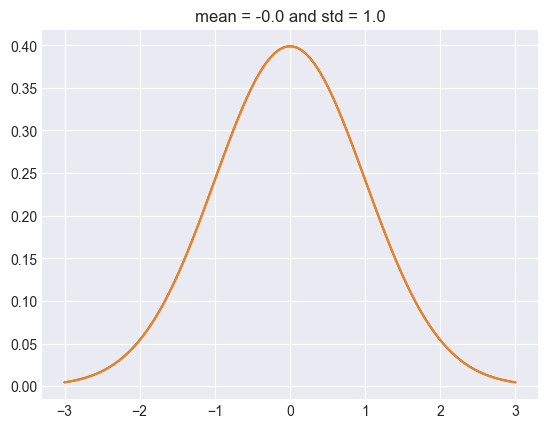

In [73]:
#generating samples and fitting it to a normal distribution
n = 2**20
dimension = len(inverseCDFs)
sobolPoints = qp.Sobol(dimension).gen_samples(n)
samples = theFunc(sobolPoints)
# samples = [[0.0] * dimension] * n
# for i in range(n):
#     samples[i] = theFunc(sobolPoints[i])
# print(samples)

mean, std = norm.fit(samples)
fig, ax = plt.subplots()
plt.plot(evalPoints, norm.pdf(evalPoints, mean, std))
plt.plot(evalPoints, truePDF(evalPoints))
ax.set_title(f"mean = {round(mean, 4)} and std = {round(std, 4)}")

In [ ]:
#averaged graphs of experiment2
fig, ax = plt.subplots(2, 3, figsize = (15, 10))
fig.suptitle("average of nr = 16 simulation for n = 2^10")
figAll, axAll = plt.subplots(1, 2, figsize = (15, 7))
figAll.suptitle("average of nr = 16 for n = 2^10 overlayed")
exp = 10
for pointSetType in ["MC", "Sobol"]:
    for i in range(3):
        conditionalDensity = conditionalDensities[i]
        yvals = np.sum(localDb[pointSetType, "conditional", conditionalDensity.__name__, exp], 0) / nr
        if pointSetType == "Sobol":
            ax[0][i].plot(evalPoints, yvals)
            ax[0][i].set_title(f"{pointSetType, conditionalDensities[i].__name__}")
            axAll[0].plot(evalPoints, yvals, label = f"{pointSetType, conditionalDensity.__name__}")
            axAll[0].legend()
        if pointSetType == "MC":
            ax[1][i].plot(evalPoints, yvals)
            ax[1][i].set_title(f"{pointSetType, conditionalDensities[i].__name__}")
            axAll[1].plot(evalPoints, yvals, label = f"{pointSetType, conditionalDensity.__name__}")
            axAll[1].legend()


1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600
1600


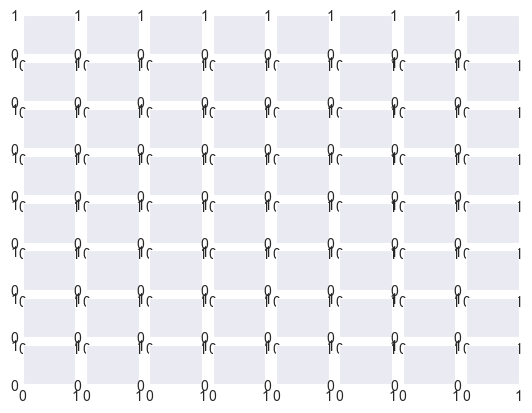

In [95]:
dbfile = open('experiment2Corrected', 'rb')
db = pickle.load(dbfile)
localDb = db
dbfile.close()

fig, ax = plt.subplots(8, 8)
xvals = np.array(range(5, 15, 1)) * np.log10(2)
for key in localDb:
    print(localDb[key].size)

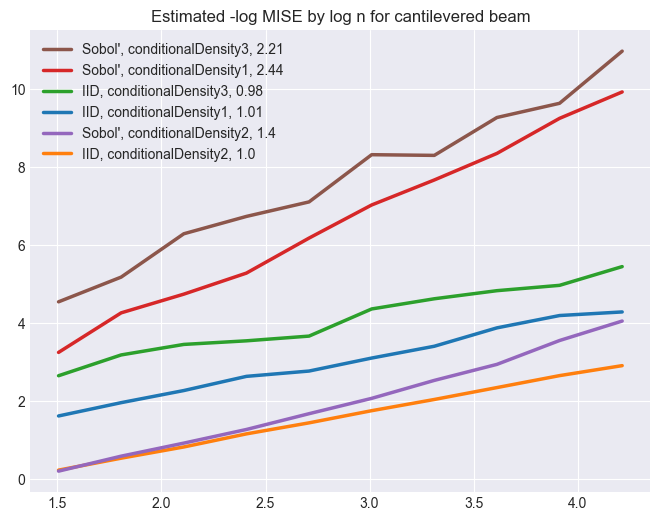

In [10]:
#error for experiment 2
dbfile = open('experiment2Corrected', 'rb')
db = pickle.load(dbfile)
localDb = db
dbfile.close()
mpl.style.use('seaborn-v0_8-darkgrid')
xvals = np.array(range(5, 15, 1))
fig, ax = plt.subplots(figsize = (8,6))
for pointSetType in ["MC", "Sobol"]:
    for conditionalDensity in conditionalDensities:
        errorVals = []
        for exp in range(5, 15 , 1):
            temp = -np.log10(calculateEstimatedMISE(localDb[pointSetType, "conditional", conditionalDensity.__name__, exp]))
            errorVals.append(temp)
        if pointSetType == "MC":
            name = "IID"
        else:
            name = "Sobol'"
        plt.plot(xvals * np.log10(2), errorVals, label = f"{name}, {conditionalDensity.__name__}, {round(stats.linregress(xvals * np.log10(2), errorVals).slope, 2)}", linewidth = 2.5)
        plt.legend()
        ax.set_title("Estimated -log MISE by log n for cantilevered beam")
handles, labels = plt.gca().get_legend_handles_labels() 
order = [5, 3, 2, 0, 4, 1]
plt.legend([handles[i] for i in order], [labels[i] for i in order]) 

In [98]:
print(kappa)

500000.0


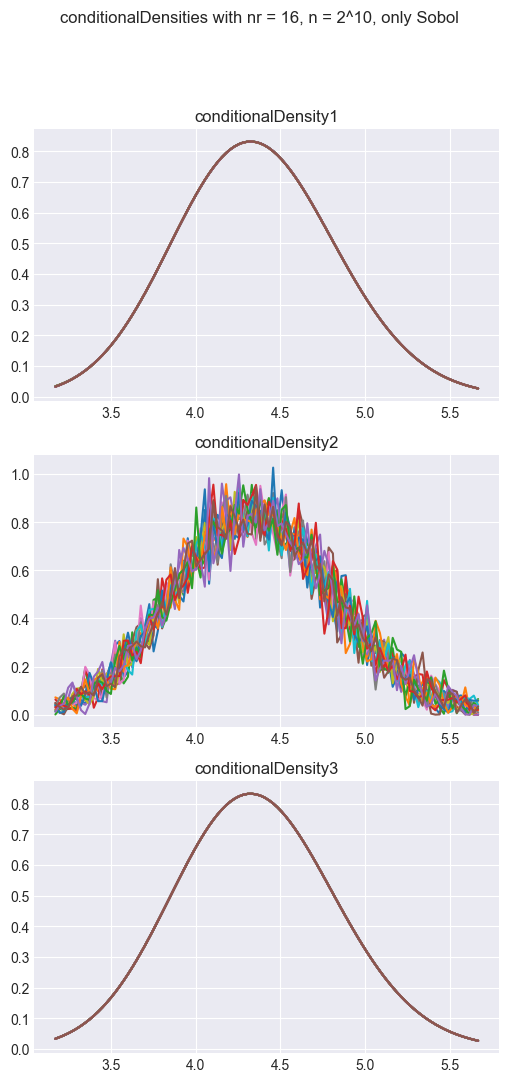

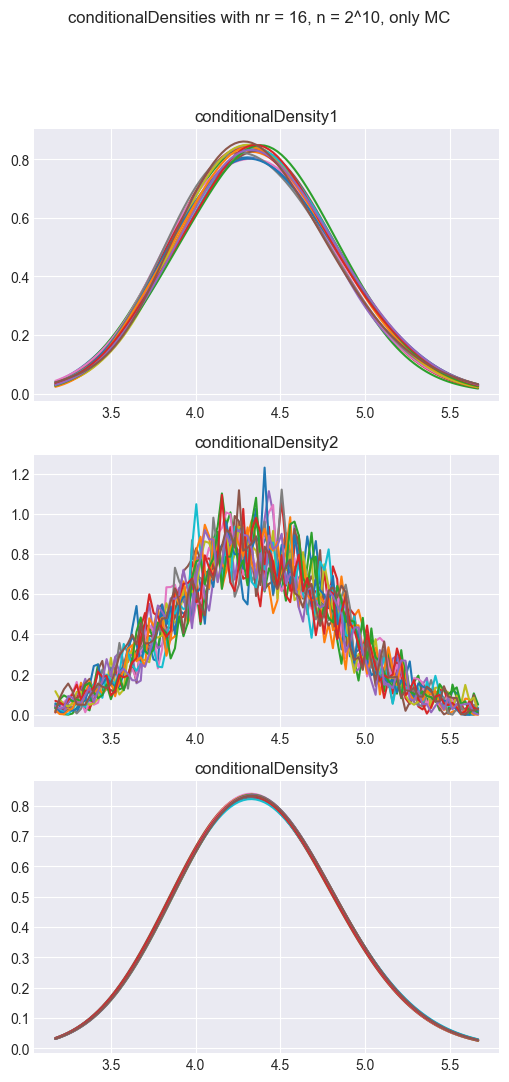

In [100]:
#many graphs of experiment2
dbfile = open('experiment2Corrected', 'rb')
db = pickle.load(dbfile)
localDb = db

nr = 16
for pointSetType in ["Sobol", "MC"]:
    fig, ax = plt.subplots(3, 1, figsize = (6, 12))
    fig.suptitle(f"conditionalDensities with nr = 16, n = 2^10, only {pointSetType}")
    for key in localDb:
        if key[0] == pointSetType:
            for i in range(nr):
                if key[2] == "conditionalDensity1" and key[3] == 10:
                    ax[0].plot(evalPoints, localDb[key][i])
                    ax[0].set_title("conditionalDensity1")
                elif key[2] == "conditionalDensity2" and key[3] == 10:
                    ax[1].plot(evalPoints, localDb[key][i])
                    ax[1].set_title("conditionalDensity2")
                elif key[2] == "conditionalDensity3" and key[3] == 10:
                    ax[2].plot(evalPoints, localDb[key][i])
                    ax[2].set_title("conditionalDensity3")

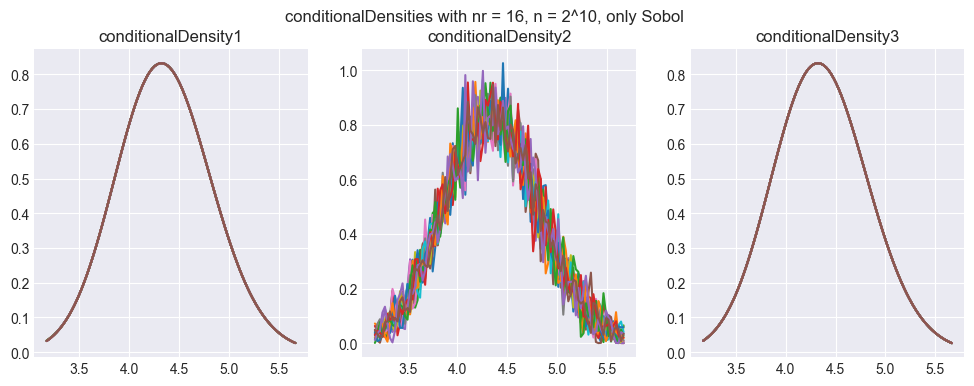

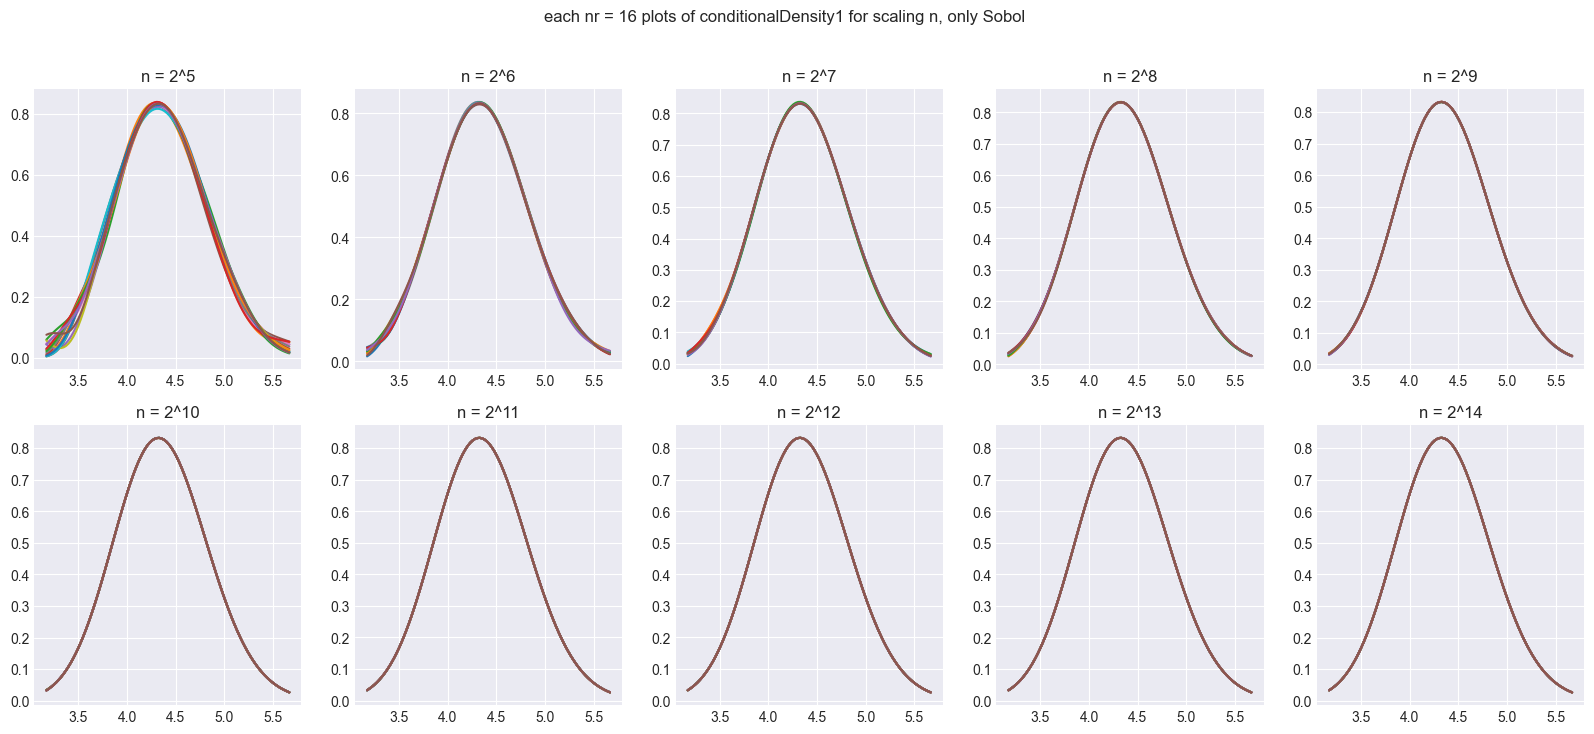

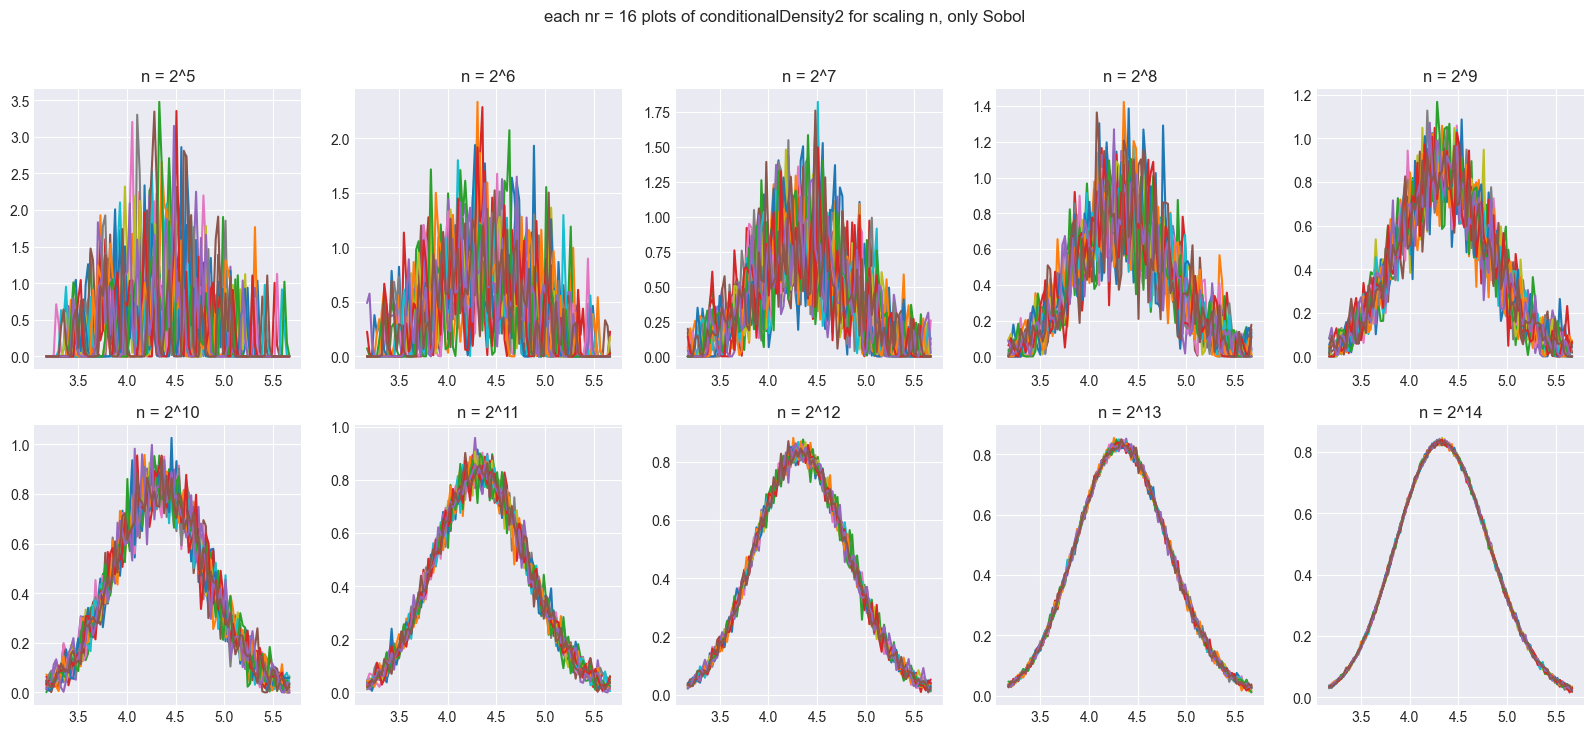

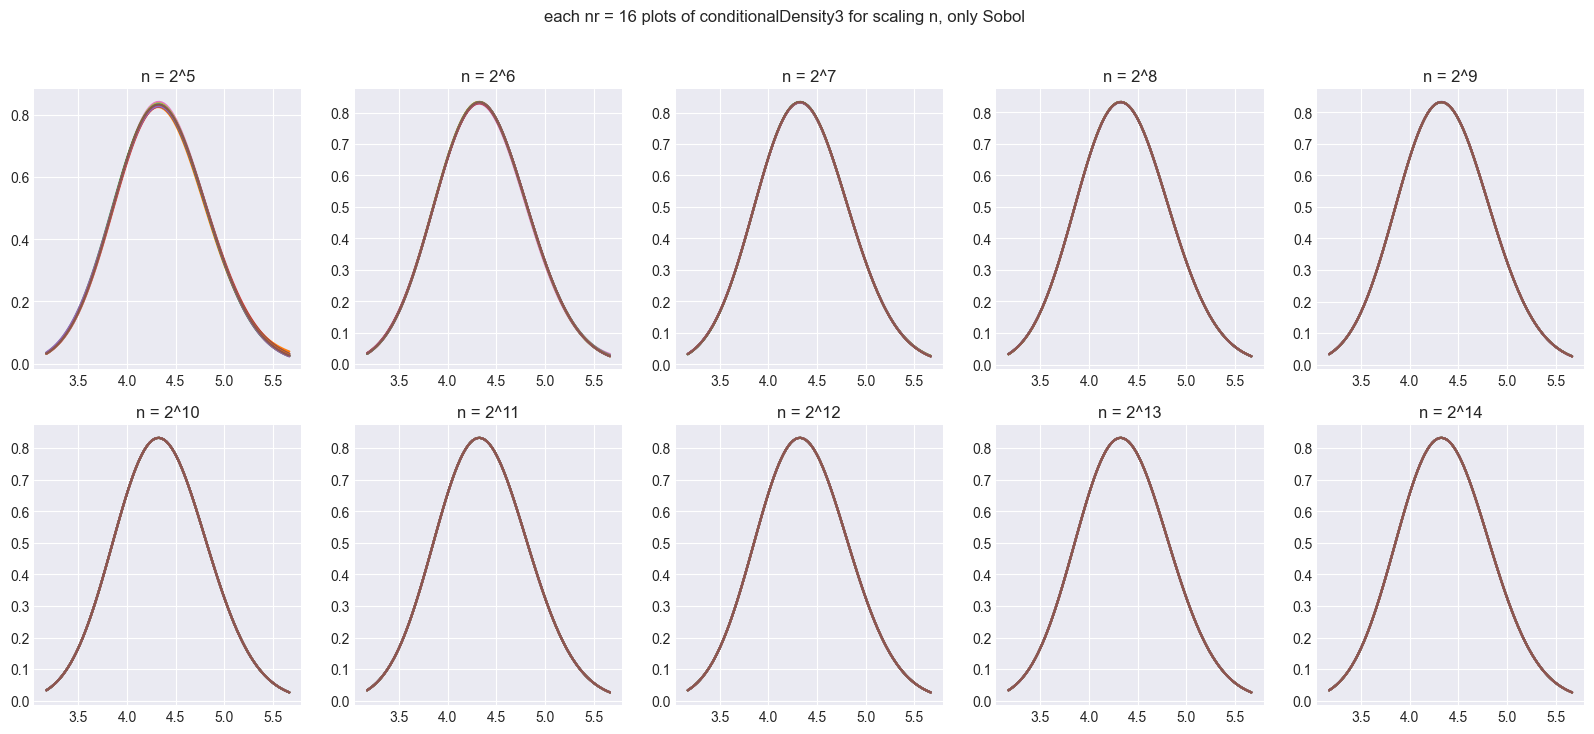

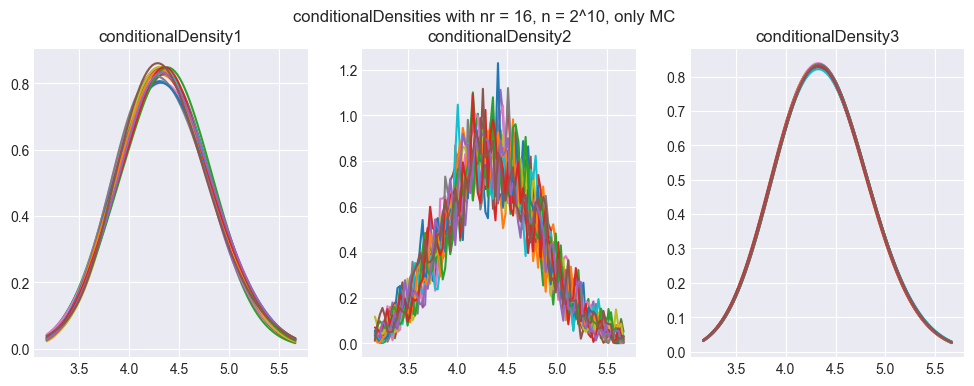

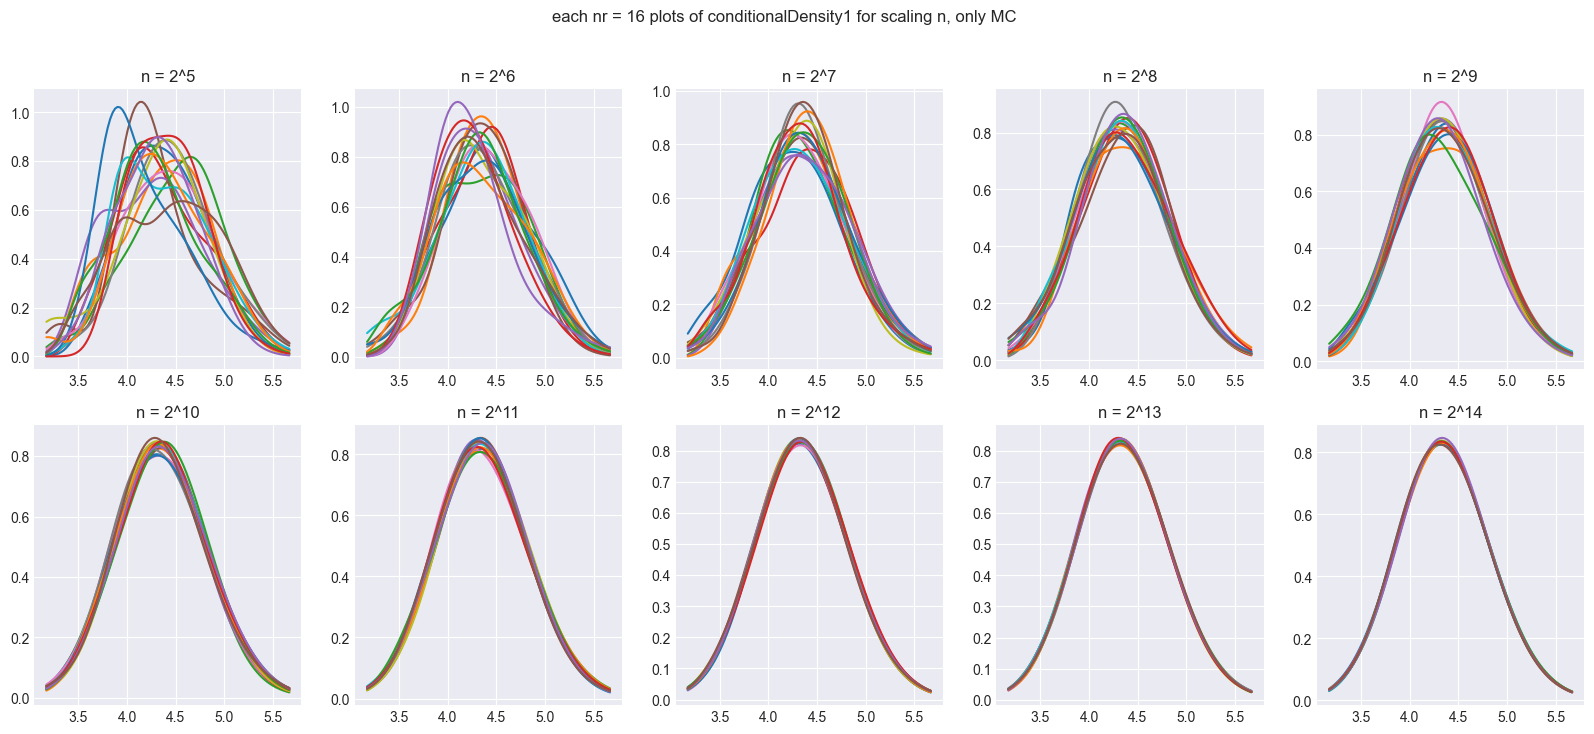

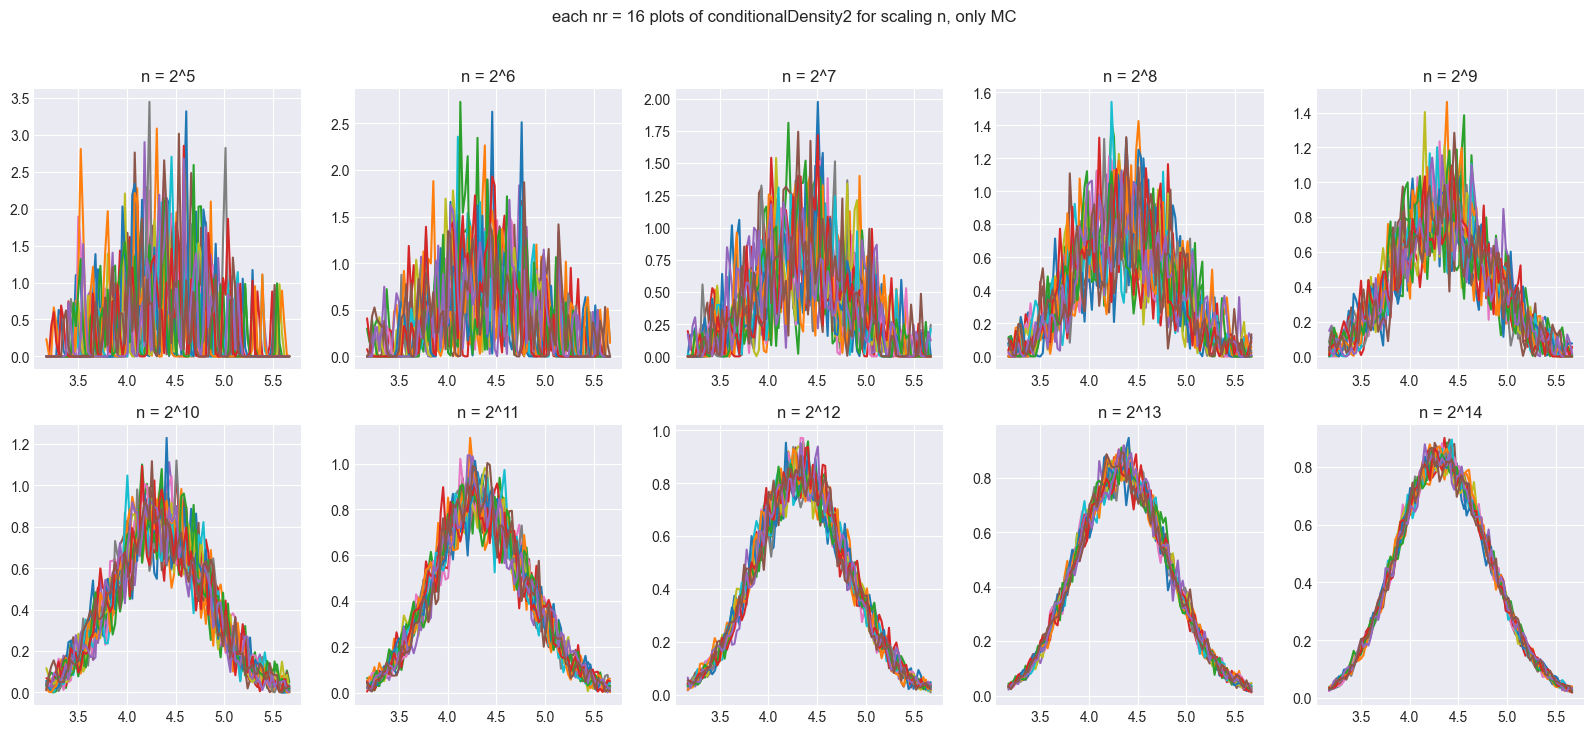

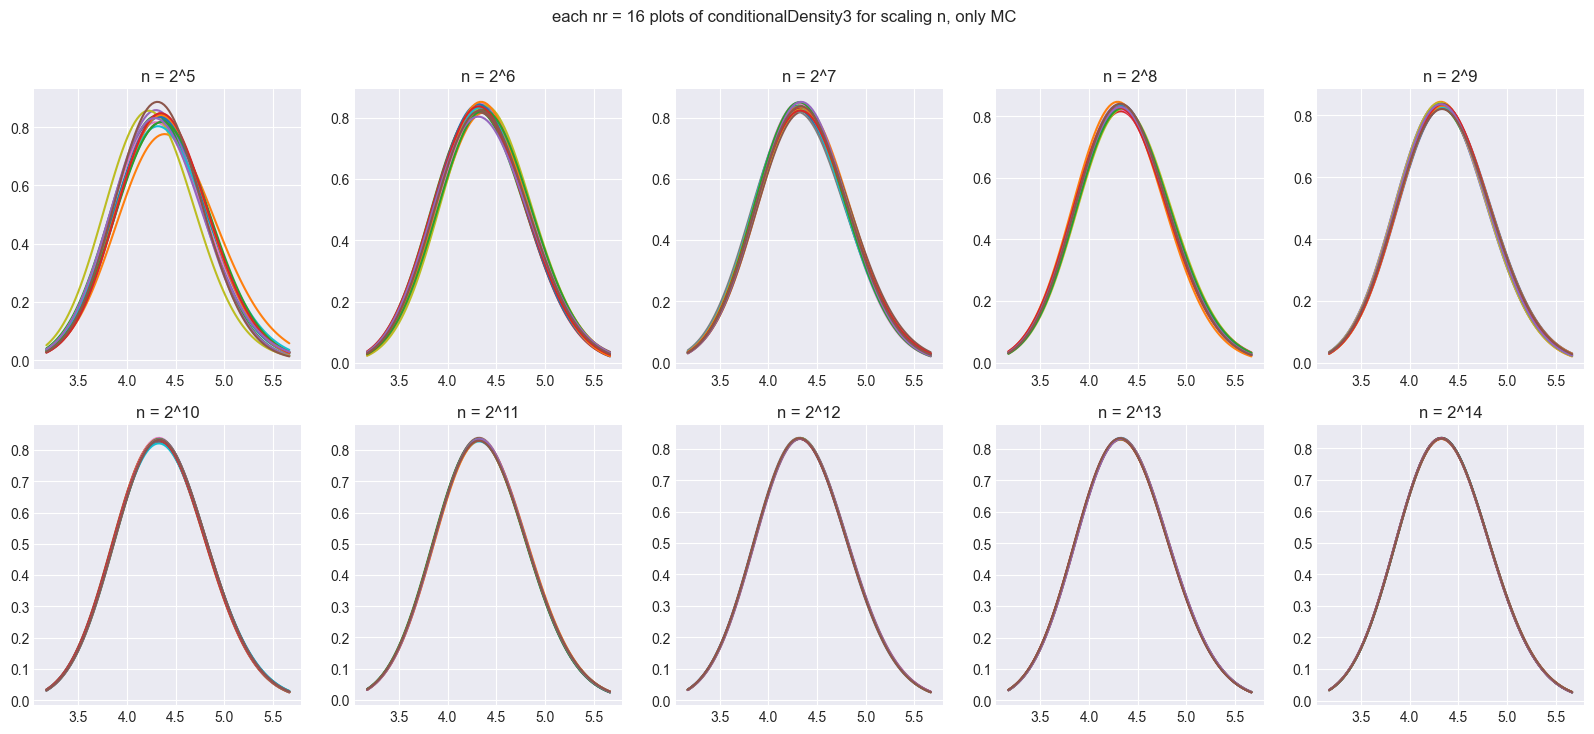

In [96]:
#many graphs of experiment2
dbfile = open('experiment2Corrected', 'rb')
db = pickle.load(dbfile)
localDb = db

nr = 16
for pointSetType in ["Sobol", "MC"]:
    fig, ax = plt.subplots(1, 3, figsize = (12, 4))
    fig.suptitle(f"conditionalDensities with nr = 16, n = 2^10, only {pointSetType}")
    for key in localDb:
        if key[0] == pointSetType:
            for i in range(nr):
                if key[2] == "conditionalDensity1" and key[3] == 10:
                    ax[0].plot(evalPoints, localDb[key][i])
                    ax[0].set_title("conditionalDensity1")
                elif key[2] == "conditionalDensity2" and key[3] == 10:
                    ax[1].plot(evalPoints, localDb[key][i])
                    ax[1].set_title("conditionalDensity2")
                elif key[2] == "conditionalDensity3" and key[3] == 10:
                    ax[2].plot(evalPoints, localDb[key][i])
                    ax[2].set_title("conditionalDensity3")

    for conditionalDensity in conditionalDensities:
        fig, ax = plt.subplots(2, 5, figsize = (20, 8))
        fig.suptitle(f"each nr = 16 plots of {conditionalDensity.__name__} for scaling n, only {pointSetType}")
        for exp in range(5, 15, 1):
            for i in range(nr):
                if exp - 5 < 5:
                    ax[0][exp - 5].plot(evalPoints, localDb[pointSetType, "conditional", conditionalDensity.__name__, exp][i])
                    ax[0][exp - 5].set_title(f"n = 2^{exp}")
                elif exp - 5 >= 5:
                    ax[1][exp - 10].plot(evalPoints, localDb[pointSetType, "conditional", conditionalDensity.__name__, exp][i])
                    ax[1][exp - 10].set_title(f"n = 2^{exp}")

dbfile.close()

In [ ]:
#data for experiment2
# nr = 16
# dict = {}
# expStart, expStop, expIncrement = 5, 15, 1
# expVals = np.array(range(expStart, expStop, expIncrement))
# for pointSetType in ["Sobol", "MC"]:
#     for method in ["conditional"]:
#         if method == "conditional":
#             for conditionalDensity in conditionalDensities:
#                 for exp in range(expStart, expStop, expIncrement):
#                     start = timer()
#                     n = 2**exp
#                     dict[pointSetType, method, conditionalDensity.__name__, exp] = generatePointsforCalculateEstimatedMISE(pointSetType, n, method, conditionalDensity, 
#                                                                "no bandwidth", inverseCDFs, evalPoints, nr)
#                     end = timer()
#                     print(pointSetType, method, conditionalDensity.__name__, exp, end - start)

# dbfile = open('experiment2Corrected', 'ab')
# pickle.dump(dict, dbfile)
# dbfile.close()

# dbfile = open('experiment2Corrected' 'rb')
# db = pickle.load(dbfile)
# localDb = db
# print(localDb)
# dbfile.close()




In [ ]:
#error histogram, not really useful
testing = 150
list1 = np.array([0.0] * testing)
list2 = np.array([0.0] * testing)
nr = 10
for i in range(testing):
    list1[i] = calculateEstimatedMISE(generatePointsforCalculateEstimatedMISE('Sobol', 2**8, "conditional", conditionalDensity3, "no bandwidth", inverseCDFs, evalPoints, nr))
    list2[i] = getTrueError(getEvaluatedPoints('Sobol', 2**8, "conditional", conditionalDensity3, "no bandwidth", inverseCDFs, evalPoints), evalPoints)

fig, ax = plt.subplots(3)
ax[0].hist(list1)
ax[1].hist(list2)
ax[2].hist(list1 - list2)



In [104]:
#pickle file got corrupted (my fault) so I got this from the github repo
#these were the results of experiment1 (weighted sum of uniforms)
dbFromGithub = {
    ('MC', 'conditional', 'conditionalDensity1') : ([3.1232477800396206, 3.8096834805839217, 4.2891843930376, 4.843869774778309, 5.526437006878188, 6.209478583144208], 1.0030372046729858),
    ('Sobol', 'conditional', 'conditionalDensity1') : ([4.399018936933285, 5.373626582282403, 6.143926972187371, 7.016837233083066, 8.225135407609418, 9.006651742476551], 1.5406913042471198),
    ('MC', 'conditional', 'conditionalDensity2') : ([3.625000985625958, 4.172391330853257, 4.668379291096744, 5.372872963626329, 5.956312031592263, 6.497775034830397], 0.9690598618504621),
    ('Sobol', 'conditional', 'conditionalDensity2') : ([5.074725809305252, 6.103895697002305, 7.155159995045782, 8.157761958698922, 8.842973088864314, 9.632363800222102], 1.5189764928443374),
    ('MC', 'conditional', 'conditionalDensity3') : ([4.391199385256805, 5.158770030718988, 5.53149954209471, 6.070369359959053, 6.832584785774641, 7.289932749585252], 0.9516840368795674),
    ('Sobol', 'conditional', 'conditionalDensity3') : ([5.926770744325015, 6.889222492963222, 7.573849478421692, 8.707904250104782, 9.613872019657054, 10.367627399410905], 1.4954507183002743),
    ('MC', 'KDE') : ([3.0876806897943423, 3.574773548377169, 4.091940154917854, 4.5393756293950505, 5.008885740021845, 5.410285937604495], 0.7765148477916677),
    ('Sobol', 'KDE') : ([3.812520461104638, 4.263305901753035, 4.726315681785227, 5.194612460816758, 5.661160362579009, 6.13288393785781], 0.7718109623405544)
}



[('MC', 'conditional', 'conditionalDensity1'), ('Sobol', 'conditional', 'conditionalDensity1'), ('MC', 'conditional', 'conditionalDensity2'), ('Sobol', 'conditional', 'conditionalDensity2'), ('MC', 'conditional', 'conditionalDensity3'), ('Sobol', 'conditional', 'conditionalDensity3'), ('MC', 'KDE'), ('Sobol', 'KDE')]


Text(0.5, 1.0, "Sobol'")

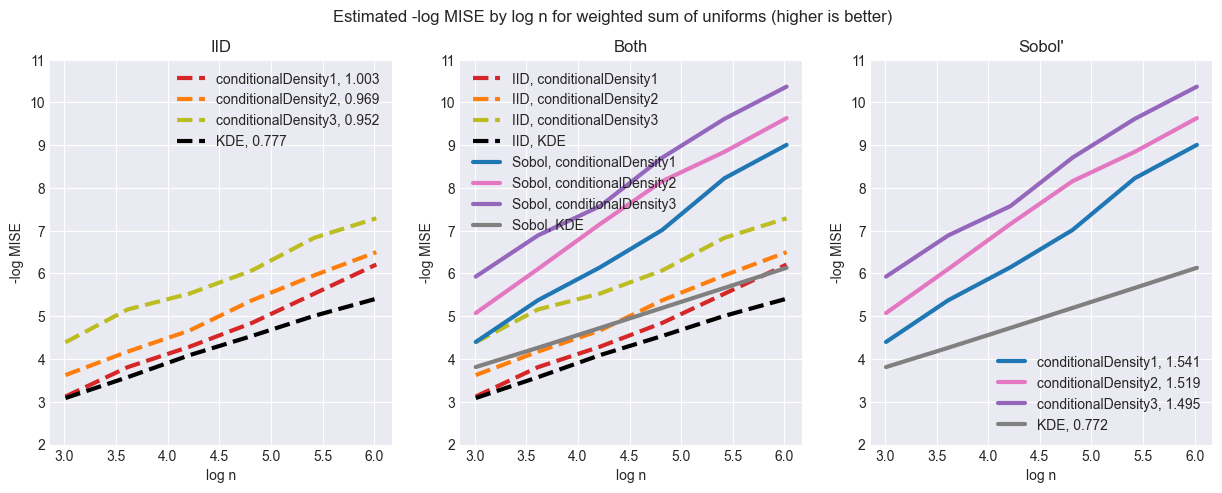

In [66]:
#error graphs for experiment 1
dbfile = open("experiment1", "rb")
loadedDb = pickle.load(dbfile)
dbfile.close()
xvals = np.array(range(10, 21, 2)) * np.log10(2)
mpl.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

keyList = list(loadedDb.keys())
print(keyList)
colorList = ["tab:red", "tab:blue", "tab:orange", "tab:pink", 
             "tab:olive", "tab:purple", "black", "gray"]

for i in [0, 2, 4, 6]:
    try:
        method = keyList[i][2]
    except:
        method = keyList[i][1]
    ax[0].plot(xvals, loadedDb[keyList[i]][0], '--', label = f"{method}, {round(loadedDb[keyList[i]][1], 3)}", color = colorList[i], linewidth = 3)
    ax[1].plot(xvals, loadedDb[keyList[i]][0], '--', label = f"IID, {method}", color = colorList[i], linewidth = 3)

for i in [1, 3, 5, 7]:
    try:
        method = keyList[i][2]
    except:
        method = keyList[i][1]
    ax[1].plot(xvals, loadedDb[keyList[i]][0], '-', label = f"Sobol, {method}", color = colorList[i], linewidth = 3)
    ax[2].plot(xvals, loadedDb[keyList[i]][0], '-', label = f"{method}, {round(loadedDb[keyList[i]][1], 3)}", color = colorList[i], linewidth = 3)


fig.suptitle("Estimated -log MISE by log n for weighted sum of uniforms (higher is better)")
for i in range(3):
    ax[i].legend()
    ax[i].set_xlabel("log n")
    ax[i].set_ylabel("-log MISE")
    ax[i].set_ylim(2, 11)

ax[0].set_title("IID")
ax[1].set_title("Both")
ax[2].set_title("Sobol'")

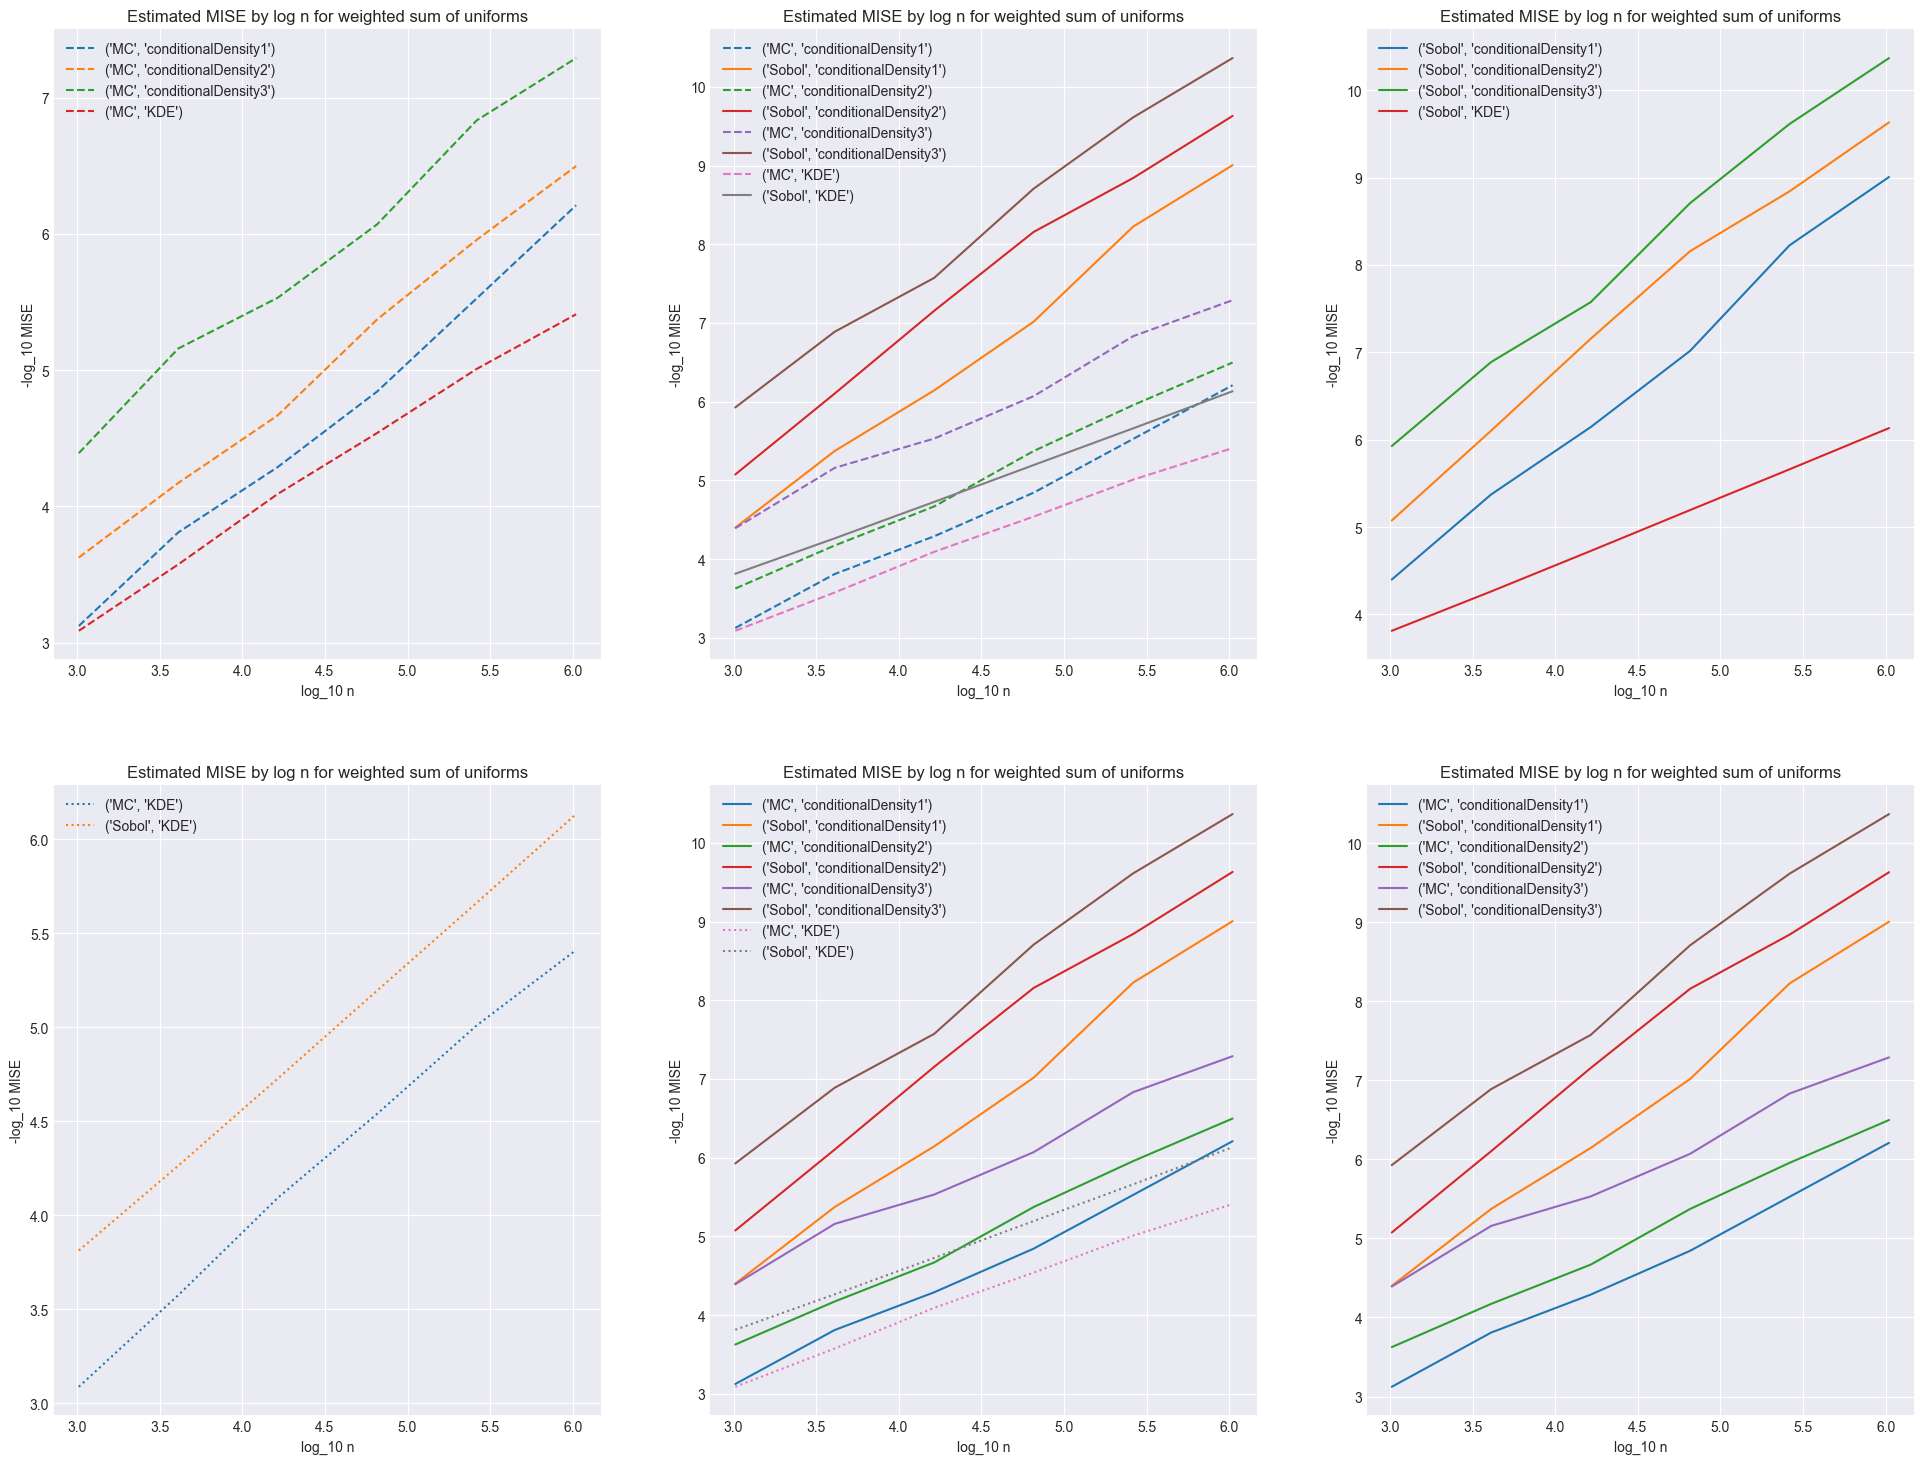

In [18]:
#error graphs for experiment 1
dbfile = open("experiment1", "rb")
loadedDb = pickle.load(dbfile)
dbfile.close()
xvals = np.array(range(10, 21, 2)) * np.log10(2)
mpl.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(2, 3, figsize = (24,18))
for key in loadedDb:
    yvals = loadedDb[key][0]
    try:
        simplified = key[0], key[2]
    except:
        simplified = key[0], key[1]
    if key[0] == "MC":
        ax[0][0].plot(xvals, yvals, '--',  label = f"{simplified}")
        ax[0][1].plot(xvals, yvals, '--' , label = f"{simplified}",)
    elif key[0] == "Sobol":
        ax[0][2].plot(xvals, yvals, label = f"{simplified}")
        ax[0][1].plot(xvals, yvals, label = f"{simplified}")
    if key[1] == 'conditional':
        ax[1][2].plot(xvals, yvals, label = f"{simplified}")
        ax[1][1].plot(xvals, yvals, label = f"{simplified}")
    if key[1] == 'KDE':
        ax[1][0].plot(xvals, yvals, ':', label = f"{simplified}")
        ax[1][1].plot(xvals, yvals, ':', label = f"{simplified}")
    
for i in range(3):
    for j in range(2):
        ax[j][i].legend()
        ax[j][i].set_title("Estimated MISE by log n for weighted sum of uniforms")
        ax[j][i].set_xlabel("log_10 n")
        ax[j][i].set_ylabel("-log_10 MISE")